# Weight-Tracker

### Written By: Jim Lanzi

This notebook fits an exponential curve through weight data for loss rate tracking and milestone prediction.

In [1]:
# First we import necessary Python modules
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from numpy import array, arange, ones, zeros, hstack, exp, asarray, log
from numpy import min as npmin
from numpy import loadtxt
from numpy.linalg import lstsq
from datetime import date, timedelta
from scipy.optimize import curve_fit

In [2]:
# Read weight versus date data from file into arrays
y,m,d,wgt = loadtxt('wtdata.txt',unpack=True)
y = y.astype(int)
m = m.astype(int)
d = d.astype(int)
dt = [date(y[i],m[i],d[i]) for i in range(0,len(y))]

In [3]:
# Set up a day count array for curve fitting
N = len(dt)
td = array([(date(y[i],m[i],d[i])-date(y[0],m[0],d[0])).days for i in range(0,len(y))])

In [4]:
# Weekly minimums
Nw = int(N / 7)
tw = 7.0 * Nw
wtByWeek = zeros((Nw))
for w in range(0, Nw):
    ww = wgt[7*w:(7*w+7)]
    wtByWeek[w] = min(ww)

In [5]:
dtwk = array([dt[6]])
for w in range(1,Nw):
    dtwk = hstack((dtwk,dtwk[-1]+timedelta(days=7)))

In [6]:
# Compute raw day-to-day loss rate
rawdwdt = arange(0.0, float(N))
for i in range(1,N):
    rawdwdt[i] = (wgt[i-1] - wgt[i])/(td[i]-td[i-1])*7.0

In [7]:
# Exponential Curve Fit
def wfit(t, w0, tc, winf):
    return (w0-winf)*exp(-t/tc) + winf

In [8]:
# Loss rate per week
def dwdt(t, w0, tc, winf):
    return (w0-winf)/tc*exp(-t/tc)*7.0 

In [9]:
# Inverse of w(t) fit function
def timeatwt(w, w0, tc, winf):
    return tc*log((w0-winf)/(w-winf))

In [10]:
# Compute curve fit parameters
popt, pcov = curve_fit(wfit, td, asarray(wgt,dtype='float64'))

In [11]:
# Pull curve fit parameters from solution
w0   = popt[0]
tc   = popt[1]
winf = popt[2]

In [12]:
# Compute Milestone Dates
startDate = date(2017, 1, 1)
date200   = startDate + timedelta(days=int(timeatwt(200.0,*popt)))
date175   = startDate + timedelta(days=int(timeatwt(175.0,*popt)))
date180   = startDate + timedelta(days=int(timeatwt(180.0,*popt)))
date185   = startDate + timedelta(days=int(timeatwt(185.0,*popt)))
date195   = startDate + timedelta(days=int(timeatwt(195.0,*popt)))
date190   = startDate + timedelta(days=int(timeatwt(190.0,*popt)))
date215   = startDate + timedelta(days=int(timeatwt(215.0,*popt)))
date210   = startDate + timedelta(days=int(timeatwt(210.0,*popt)))
date205   = startDate + timedelta(days=int(timeatwt(205.0,*popt)))
dateinf   = startDate + timedelta(days=int(timeatwt(winf+5,*popt)))
dateWeek  = dt[-1] + timedelta(days=7)

In [13]:
slopeLabel = 'Loss Rate: %.2f lb/week' % (dwdt(td[-1],*popt))
weightLabel = 'Projected Wt Today: %.1f' % (wfit(td[-1],*popt))

In [14]:
# Extend day count for plotting fit
lookAheadWt = wgt[-1] - 2.0
#lookAheadWt = 180.0
lookAheadDays = int(timeatwt(lookAheadWt,*popt) - td[-1])+1
tdplt = hstack((td,arange(1,lookAheadDays)+td[-1]))
dtplt = dt
for d in range(1,lookAheadDays):
    dtplt = hstack((dtplt,dtplt[-1]+timedelta(days=1)))

In [15]:
fig,ax1 = plt.subplots(figsize=[8,7])
ax1.plot(dt, wgt,'-')
ax1.plot(dtplt, wfit(tdplt,*popt), 'r', label=weightLabel)
ax1.plot(dtwk, wtByWeek,'g--')
ax1.grid(True)
ax1.set_ylabel('Weight - lb')
ax1.set_ylim(180,235)
ax1.legend()
ax1.xaxis.set_major_formatter(DateFormatter('%m/%d/%Y'))
fig.autofmt_xdate()
#plt.gcf().axes[0].xaxis.set_major_formatter(DateFormatter('%m/%d/%Y'))
#plt.gcf().autofmt_xdate()

#ax2 = ax1.twinx()
#ax2.plot(dtplt, dwdt(tdplt,*popt),'g',label=slopeLabel)
#ax2.set_ylabel('Loss Rate - lb/week',color='g')
#ax2.set_ylim(0.0, 3.5)
#ax2.tick_params('y',colors='g')
#ax2.legend(loc='lower left')
fig.tight_layout()


In [16]:
fig = plt.figure(figsize=[8,6])
plt.plot(dt, rawdwdt)
plt.plot(dtplt, dwdt(tdplt,*popt),'r', label=slopeLabel)
plt.grid(True)
plt.ylabel('Loss Rate - lb/week')
plt.legend()
plt.gcf().axes[0].xaxis.set_major_formatter(DateFormatter('%m/%d/%Y'))
plt.gcf().autofmt_xdate()
fig.tight_layout()

In [17]:
fig = plt.figure(figsize=[8,6])
plt.plot(dt, wgt-wfit(td,*popt))
plt.grid(True)
plt.ylabel('Delta Weight from Trend - lb')
plt.gcf().axes[0].xaxis.set_major_formatter(DateFormatter('%m/%d/%Y'))
plt.gcf().autofmt_xdate()
fig.tight_layout()

In [18]:
print(slopeLabel)
print(weightLabel)
print('Curve Fit: w0: %.1f lb, winf: %.1f lb, tc: %.1f days' % (w0, winf, tc))
print('On Program for %d days' % td[-1])
#print('Expect to hit 215lb on %d/%d' % (date215.month,date215.day))
#print('Expect to hit 210lb on %d/%d' % (date210.month,date210.day))
#print('Expect to hit 205lb on %d/%d' % (date205.month,date205.day))
#print('Expect to hit 200lb on %d/%d' % (date200.month,date200.day))
#print('Expect to hit 195lb on %d/%d' % (date195.month,date195.day))
print('Expect to hit 190lb on %d/%d' % (date190.month,date190.day))
print('Expect to hit 185lb on %d/%d' % (date185.month,date185.day))
print('Expect to hit 180lb on %d/%d' % (date180.month,date180.day))
print('Expect to hit 175lb on %d/%d' % (date175.month,date175.day))
print('Expect to hit wnf+5 on %d/%d/%d' % (dateinf.month,dateinf.day,dateinf.year))

Loss Rate: 0.69 lb/week
Projected Wt Today: 186.4
Curve Fit: w0: 231.1 lb, winf: 165.3 lb, tc: 214.7 days
On Program for 244 days
Expect to hit 190lb on 7/30
Expect to hit 185lb on 9/17
Expect to hit 180lb on 11/19
Expect to hit 175lb on 2/16
Expect to hit wnf+5 on 7/8/2018


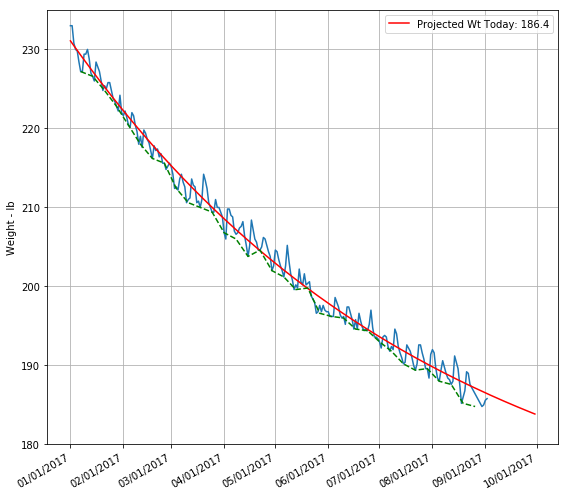

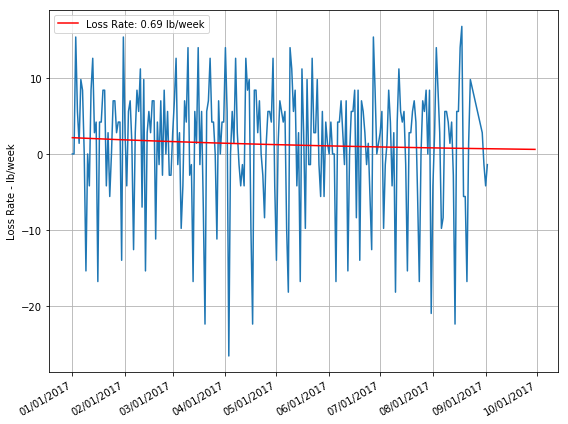

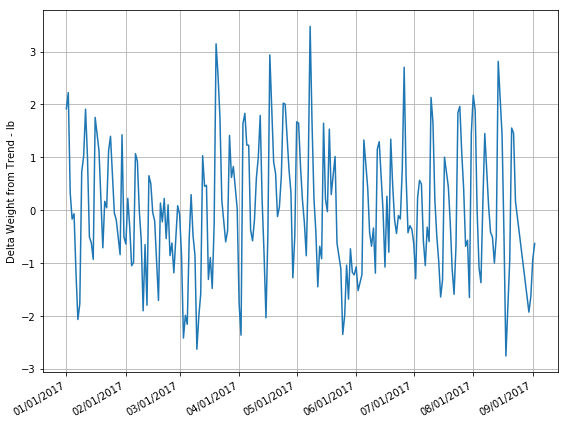

In [19]:
plt.show()